In [1]:
# ==========================================
# PART 1 : EfficientNet + 幾何保留策略
# ==========================================
!pip install roboflow opencv-python matplotlib scikit-learn tensorflow seaborn

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import mixed_precision
from sklearn.utils import class_weight
from roboflow import Roboflow

try:
    from google.colab import files
except ImportError:
    pass

# 0. 清理舊模型與環境
tf.keras.backend.clear_session()
if os.path.exists('my_mri_model.h5'):
    os.remove('my_mri_model.h5')

# 開啟混合精度加速 (報告中提到的 Mixed Precision)
mixed_precision.set_global_policy('mixed_float16')

# 1. 下載資料
rf = Roboflow(api_key="Fejkqw1NB22U2OhV41Ph")
project = rf.workspace("mri-l4mg5").project("mri-brain-tumor-nxio6")
version = project.version(2)
dataset = version.download("folder")

dataset_path = dataset.location
train_dir = os.path.join(dataset_path, "train")
valid_dir = os.path.join(dataset_path, "valid")

# 2. 影像前處理 (報告中提到的 CLAHE 技術)
def report_preprocessing(img):
    img = img.astype('uint8')
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    # CLAHE: 限制對比度自適應直方圖均衡化
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    img_enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return img_enhanced.astype('float32')

# 3. 資料生成 (⚠️ 關鍵修正：幾何保留策略)
# 對應報告：修正了過度旋轉導致位置特徵遺失的問題
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_datagen = ImageDataGenerator(
    preprocessing_function=report_preprocessing,
    # 🔥 修改點：將旋轉與位移降至極低，僅模擬些微誤差
    rotation_range=2,        # 從 20 改為 2 (幾乎不旋轉)
    width_shift_range=0.02,  # 從 0.1 改為 0.02
    height_shift_range=0.02, # 從 0.1 改為 0.02
    zoom_range=0.02,         # 降低縮放幅度
    brightness_range=[0.8, 1.2], # 保留亮度變化以適應不同成像條件
    horizontal_flip=True,    # 左右翻轉是解剖學上合理的 (人腦對稱)
    fill_mode='nearest',
    rescale=1./255
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=report_preprocessing,
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

# 4. 權重計算 (報告中提到的類別不平衡處理)
original_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(original_weights))

# 針對 Glioma 給予權重加成 (解決誤判問題)
indices = train_generator.class_indices
glioma_idx = indices.get('glioma_tumor')
if glioma_idx is not None:
    class_weights_dict[glioma_idx] *= 2.0
    print(f"🔥 實施 Glioma 權重加強策略: {class_weights_dict}")

# 5. 建立模型 (報告中提到的 EfficientNetB0 架構)
# include_top=False: 移除原分類層
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 🔥 全模型解鎖 (Full Unfreeze)：適應 MRI 特殊紋理
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x) # 報告提到的 GAP 層

# 報告提到的分類頭設計 (Dense + BN + Dropout)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)

predictions = Dense(train_generator.num_classes, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 6. 編譯設定 (報告中提到的極低學習率策略)
model.compile(optimizer=Adam(learning_rate=1e-5), # 1e-5 = 0.00001
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 7. 訓練設定
checkpoint = ModelCheckpoint('my_mri_model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

print("🚀 啟動 EfficientNet 全域微調 (幾何保留模式)...")

history = model.fit(
    train_generator,
    epochs=40,
    validation_data=valid_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

print("\n✅ 訓練完成！模型已符合報告所述之幾何保留策略。")
try:
    files.download('my_mri_model.h5')
except:
    pass

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 66.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MRI-Brain-Tumor-2 in folder:: 100%|██████████| 6669/6669 [00:01<00:00, 4507.61it/s]


Found 5826 images belonging to 4 classes.
Found 547 images belonging to 4 classes.
🔥 實施 Glioma 權重加強策略: {0: np.float64(1.7185840707964601), 1: np.float64(0.8517543859649123), 2: np.float64(2.074786324786325), 3: np.float64(0.8472949389179756)}
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🚀 啟動 EfficientNet 全域微調 (幾何保留模式)...


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.2811 - loss: 2.2971
Epoch 1: val_accuracy improved from -inf to 0.18464, saving model to my_mri_model.h5


365/365 ━━━━━━━━━━━━━━━━━━━━ 466s 739ms/step - accuracy: 0.2811 - loss: 2.2968 - val_accuracy: 0.1846 - val_loss: 1.7173 - learning_rate: 1.0000e-05
Epoch 2/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.3742 - loss: 1.8769
Epoch 2: val_accuracy improved from 0.18464 to 0.55759, saving model to my_mri_model.h5


365/365 ━━━━━━━━━━━━━━━━━━━━ 97s 266ms/step - accuracy: 0.3742 - loss: 1.8768 - val_accuracy: 0.5576 - val_loss: 1.0739 - learning_rate: 1.0000e-05
Epoch 3/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.4501 - loss: 1.7015
Epoch 3: val_accuracy improved from 0.55759 to 0.67276, saving model to my_mri_model.h5


365/365 ━━━━━━━━━━━━━━━━━━━━ 97s 264ms/step - accuracy: 0.4502 - loss: 1.7013 - val_accuracy: 0.6728 - val_loss: 0.8855 - learning_rate: 1.0000e-05
Epoch 4/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5037 - loss: 1.4356
Epoch 4: val_accuracy improved from 0.67276 to 0.69835, saving model to my_mri_model.h5


365/365 ━━━━━━━━━━━━━━━━━━━━ 98s 267ms/step - accuracy: 0.5037 - loss: 1.4356 - val_accuracy: 0.6984 - val_loss: 0.8143 - learning_rate: 1.0000e-05
Epoch 5/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5468 - loss: 1.3264
Epoch 5: val_accuracy improved from 0.69835 to 0.72212, saving model to my_mri_model.h5


365/365 ━━━━━━━━━━━━━━━━━━━━ 96s 263ms/step - accuracy: 0.5469 - loss: 1.3263 - val_accuracy: 0.7221 - val_loss: 0.7899 - learning_rate: 1.0000e-05
Epoch 6/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.6028 - loss: 1.1834
Epoch 6: val_accuracy did not improve from 0.72212
365/365 ━━━━━━━━━━━━━━━━━━━━ 96s 262ms/step - accuracy: 0.6028 - loss: 1.1833 - val_accuracy: 0.7020 - val_loss: 0.8361 - learning_rate: 1.0000e-05
Epoch 7/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.6227 - loss: 1.0950
Epoch 7: val_accuracy improved from 0.72212 to 0.74223, saving model to my_mri_model.h5


365/365 ━━━━━━━━━━━━━━━━━━━━ 96s 264ms/step - accuracy: 0.6227 - loss: 1.0950 - val_accuracy: 0.7422 - val_loss: 0.7467 - learning_rate: 1.0000e-05
Epoch 8/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.6474 - loss: 0.9928
Epoch 8: val_accuracy improved from 0.74223 to 0.78611, saving model to my_mri_model.h5


365/365 ━━━━━━━━━━━━━━━━━━━━ 98s 268ms/step - accuracy: 0.6474 - loss: 0.9928 - val_accuracy: 0.7861 - val_loss: 0.6167 - learning_rate: 1.0000e-05
Epoch 9/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.6868 - loss: 0.9298
Epoch 9: val_accuracy improved from 0.78611 to 0.80622, saving model to my_mri_model.h5


365/365 ━━━━━━━━━━━━━━━━━━━━ 96s 263ms/step - accuracy: 0.6869 - loss: 0.9297 - val_accuracy: 0.8062 - val_loss: 0.6113 - learning_rate: 1.0000e-05
Epoch 10/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.7016 - loss: 0.9079
Epoch 10: val_accuracy improved from 0.80622 to 0.80804, saving model to my_mri_model.h5


365/365 ━━━━━━━━━━━━━━━━━━━━ 96s 263ms/step - accuracy: 0.7017 - loss: 0.9079 - val_accuracy: 0.8080 - val_loss: 0.5610 - learning_rate: 1.0000e-05
Epoch 11/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7224 - loss: 0.8226
Epoch 11: val_accuracy did not improve from 0.80804
365/365 ━━━━━━━━━━━━━━━━━━━━ 95s 261ms/step - accuracy: 0.7224 - loss: 0.8226 - val_accuracy: 0.7770 - val_loss: 0.6716 - learning_rate: 1.0000e-05
Epoch 12/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7331 - loss: 0.7532
Epoch 12: val_accuracy did not improve from 0.80804
365/365 ━━━━━━━━━━━━━━━━━━━━ 144s 266ms/step - accuracy: 0.7332 - loss: 0.7532 - val_accuracy: 0.8007 - val_loss: 0.5837 - learning_rate: 1.0000e-05
Epoch 13/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.7484 - loss: 0.7174
Epoch 13: val_accuracy did not improve from 0.80804
365/365 ━━━━━━━━━━━━━━━━━━━━ 95s 261ms/step - accuracy: 0.7484 - loss: 0.7174 - val_accuracy: 0.7824 - val_loss: 0.7031 - learning_r

365/365 ━━━━━━━━━━━━━━━━━━━━ 95s 260ms/step - accuracy: 0.7636 - loss: 0.7144 - val_accuracy: 0.8336 - val_loss: 0.5098 - learning_rate: 5.0000e-06
Epoch 15/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7776 - loss: 0.6476
Epoch 15: val_accuracy improved from 0.83364 to 0.84461, saving model to my_mri_model.h5


365/365 ━━━━━━━━━━━━━━━━━━━━ 146s 271ms/step - accuracy: 0.7776 - loss: 0.6476 - val_accuracy: 0.8446 - val_loss: 0.4888 - learning_rate: 5.0000e-06
Epoch 16/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.7786 - loss: 0.6758
Epoch 16: val_accuracy did not improve from 0.84461
365/365 ━━━━━━━━━━━━━━━━━━━━ 98s 267ms/step - accuracy: 0.7786 - loss: 0.6757 - val_accuracy: 0.8336 - val_loss: 0.5416 - learning_rate: 5.0000e-06
Epoch 17/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7774 - loss: 0.6438
Epoch 17: val_accuracy did not improve from 0.84461
365/365 ━━━━━━━━━━━━━━━━━━━━ 95s 260ms/step - accuracy: 0.7774 - loss: 0.6438 - val_accuracy: 0.8355 - val_loss: 0.5145 - learning_rate: 5.0000e-06
Epoch 18/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7983 - loss: 0.6069
Epoch 18: val_accuracy did not improve from 0.84461
365/365 ━━━━━━━━━━━━━━━━━━━━ 95s 261ms/step - accuracy: 0.7983 - loss: 0.6069 - val_accuracy: 0.8300 - val_loss: 0.5265 - learning_r

365/365 ━━━━━━━━━━━━━━━━━━━━ 97s 266ms/step - accuracy: 0.7986 - loss: 0.5826 - val_accuracy: 0.8556 - val_loss: 0.4793 - learning_rate: 2.5000e-06
Epoch 21/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8012 - loss: 0.6122
Epoch 21: val_accuracy did not improve from 0.85558
365/365 ━━━━━━━━━━━━━━━━━━━━ 96s 264ms/step - accuracy: 0.8012 - loss: 0.6122 - val_accuracy: 0.8519 - val_loss: 0.4988 - learning_rate: 2.5000e-06
Epoch 22/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8028 - loss: 0.6027
Epoch 22: val_accuracy did not improve from 0.85558
365/365 ━━━━━━━━━━━━━━━━━━━━ 95s 261ms/step - accuracy: 0.8027 - loss: 0.6027 - val_accuracy: 0.8519 - val_loss: 0.4904 - learning_rate: 2.5000e-06
Epoch 23/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8022 - loss: 0.5899
Epoch 23: val_accuracy improved from 0.85558 to 0.86106, saving model to my_mri_model.h5


365/365 ━━━━━━━━━━━━━━━━━━━━ 97s 265ms/step - accuracy: 0.8022 - loss: 0.5899 - val_accuracy: 0.8611 - val_loss: 0.4458 - learning_rate: 2.5000e-06
Epoch 24/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8230 - loss: 0.5432
Epoch 24: val_accuracy did not improve from 0.86106
365/365 ━━━━━━━━━━━━━━━━━━━━ 96s 264ms/step - accuracy: 0.8230 - loss: 0.5433 - val_accuracy: 0.8483 - val_loss: 0.4970 - learning_rate: 2.5000e-06
Epoch 25/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.7983 - loss: 0.6008
Epoch 25: val_accuracy did not improve from 0.86106
365/365 ━━━━━━━━━━━━━━━━━━━━ 96s 264ms/step - accuracy: 0.7983 - loss: 0.6008 - val_accuracy: 0.8501 - val_loss: 0.4722 - learning_rate: 2.5000e-06
Epoch 26/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.8018 - loss: 0.5749
Epoch 26: val_accuracy did not improve from 0.86106
365/365 ━━━━━━━━━━━━━━━━━━━━ 95s 261ms/step - accuracy: 0.8018 - loss: 0.5749 - val_accuracy: 0.8592 - val_loss: 0.4727 - learning_ra

365/365 ━━━━━━━━━━━━━━━━━━━━ 97s 266ms/step - accuracy: 0.8003 - loss: 0.5824 - val_accuracy: 0.8647 - val_loss: 0.4313 - learning_rate: 1.2500e-06
Epoch 30/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8055 - loss: 0.5462
Epoch 30: val_accuracy did not improve from 0.86472
365/365 ━━━━━━━━━━━━━━━━━━━━ 95s 260ms/step - accuracy: 0.8055 - loss: 0.5462 - val_accuracy: 0.8611 - val_loss: 0.4339 - learning_rate: 1.2500e-06
Epoch 31/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8088 - loss: 0.5508
Epoch 31: val_accuracy did not improve from 0.86472
365/365 ━━━━━━━━━━━━━━━━━━━━ 95s 261ms/step - accuracy: 0.8089 - loss: 0.5508 - val_accuracy: 0.8556 - val_loss: 0.4577 - learning_rate: 1.2500e-06
Epoch 32/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8142 - loss: 0.5616
Epoch 32: val_accuracy did not improve from 0.86472
365/365 ━━━━━━━━━━━━━━━━━━━━ 96s 263ms/step - accuracy: 0.8143 - loss: 0.5615 - val_accuracy: 0.8556 - val_loss: 0.4539 - learning_ra

365/365 ━━━━━━━━━━━━━━━━━━━━ 96s 263ms/step - accuracy: 0.8131 - loss: 0.5465 - val_accuracy: 0.8665 - val_loss: 0.4474 - learning_rate: 6.2500e-07
Epoch 35/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.8181 - loss: 0.5478
Epoch 35: val_accuracy did not improve from 0.86654
365/365 ━━━━━━━━━━━━━━━━━━━━ 94s 258ms/step - accuracy: 0.8181 - loss: 0.5478 - val_accuracy: 0.8665 - val_loss: 0.4391 - learning_rate: 6.2500e-07
Epoch 36/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8176 - loss: 0.5661
Epoch 36: val_accuracy improved from 0.86654 to 0.87020, saving model to my_mri_model.h5


365/365 ━━━━━━━━━━━━━━━━━━━━ 97s 265ms/step - accuracy: 0.8176 - loss: 0.5661 - val_accuracy: 0.8702 - val_loss: 0.4361 - learning_rate: 3.1250e-07
Epoch 37/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8231 - loss: 0.5256
Epoch 37: val_accuracy did not improve from 0.87020
365/365 ━━━━━━━━━━━━━━━━━━━━ 96s 263ms/step - accuracy: 0.8231 - loss: 0.5256 - val_accuracy: 0.8665 - val_loss: 0.4382 - learning_rate: 3.1250e-07
Epoch 38/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.8179 - loss: 0.4986
Epoch 38: val_accuracy did not improve from 0.87020
365/365 ━━━━━━━━━━━━━━━━━━━━ 97s 265ms/step - accuracy: 0.8178 - loss: 0.4987 - val_accuracy: 0.8647 - val_loss: 0.4393 - learning_rate: 3.1250e-07
Epoch 39/40
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8338 - loss: 0.5074
Epoch 39: val_accuracy did not improve from 0.87020
365/365 ━━━━━━━━━━━━━━━━━━━━ 95s 261ms/step - accuracy: 0.8338 - loss: 0.5075 - val_accuracy: 0.8629 - val_loss: 0.4536 - learning_ra

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🔄 正在讀取模型 'my_mri_model.h5' ...


✅ 模型載入成功！

【 步驟 1 】請上傳一批「同一種類別」的照片


Saving image.jpg to image (4).jpg
Saving image(1).jpg to image(1) (4).jpg
Saving image(2).jpg to image(2) (4).jpg
Saving image(3).jpg to image(3) (4).jpg
Saving image(5).jpg to image(5) (4).jpg
Saving image(6).jpg to image(6) (4).jpg
Saving image(7).jpg to image(7) (4).jpg
Saving image(8).jpg to image(8) (4).jpg
Saving image(10).jpg to image(10) (4).jpg
Saving image(11).jpg to image(11) (4).jpg
Saving image(13).jpg to image(13) (4).jpg
Saving image(15).jpg to image(15) (4).jpg
Saving image(18).jpg to image(18) (4).jpg
Saving image(19).jpg to image(19) (4).jpg
Saving image(20).jpg to image(20) (4).jpg
Saving image(21).jpg to image(21) (4).jpg
Saving image(22).jpg to image(22) (4).jpg
Saving image(23).jpg to image(23) (4).jpg
Saving image(27).jpg to image(27) (4).jpg
Saving image(28).jpg to image(28) (4).jpg
Saving image(30).jpg to image(30) (4).jpg
Saving image(31).jpg to image(31) (4).jpg
Saving image(34).jpg to image(34) (4).jpg
Saving image(35).jpg to image(35) (4).jpg
Saving image(3

Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.


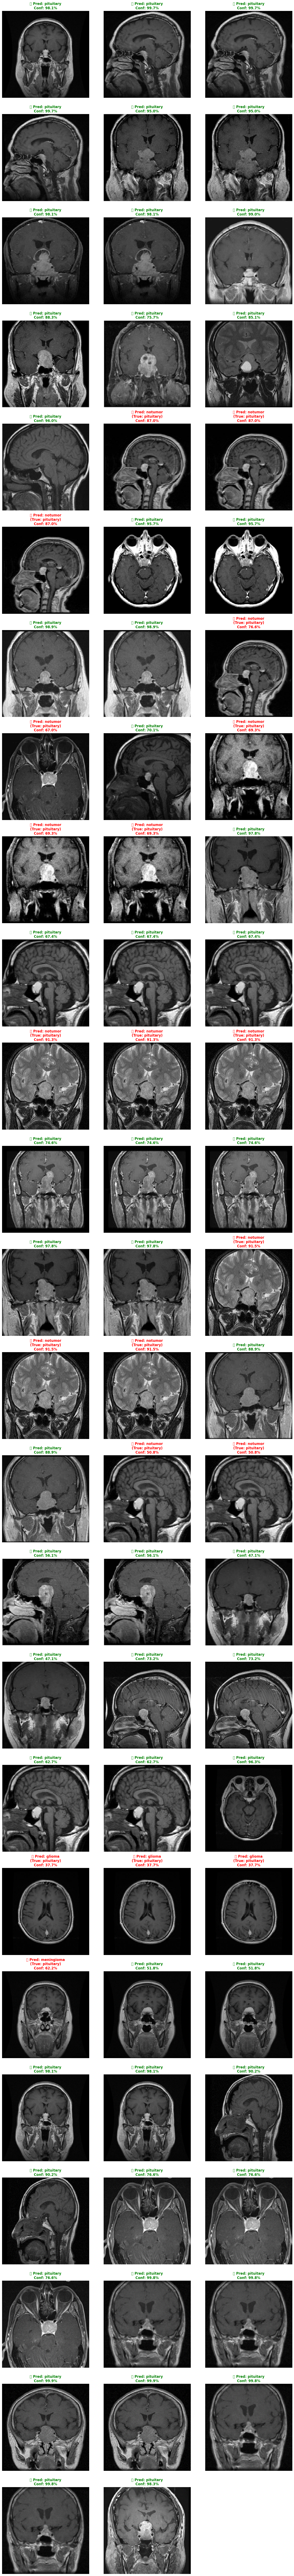


📊 測試報告 (Ground Truth: pituitary)
----------------------------------------
總張數    : 74
答對張數  : 54
答錯張數  : 20
----------------------------------------
🏆 本次準確率 : 72.97%


In [6]:
# ==========================================
# PART 2 (測試)
# ==========================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import math

# 1. 定義影像前處理 (必須與訓練時一模一樣)
def report_preprocessing(img):
    img = img.astype('uint8')
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    # 這裡維持 2.0，因為這是您剛才 EfficientNet 用的參數
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    img_enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return img_enhanced.astype('float32')

# 2. 載入模型
print("🔄 正在讀取模型 'my_mri_model.h5' ...")

if not os.path.exists('my_mri_model.h5'):
    print("❌ 錯誤：找不到模型檔案！請確認 Part 1 是否已跑完並存檔。")
else:
    # 載入模型 (需傳入自定義函數)
    model = load_model('my_mri_model.h5', custom_objects={'report_preprocessing': report_preprocessing})
    print("✅ 模型載入成功！")

    # 定義類別 (Roboflow 預設排序)
    class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

    print("\n" + "="*40)
    print("【 步驟 1 】請上傳一批「同一種類別」的照片")
    print("="*40)
    uploaded = files.upload()

    # 如果有上傳檔案
    if len(uploaded) > 0:
        num_files = len(uploaded)

        # 3. 詢問使用者正確答案
        print("\n" + "="*40)
        print("【 步驟 2 】請告訴我這批照片的正確答案是誰？")
        print(f" 0 : {class_labels[0]} (神經膠質瘤)")
        print(f" 1 : {class_labels[1]} (腦膜瘤)")
        print(f" 2 : {class_labels[2]} (無腫瘤)")
        print(f" 3 : {class_labels[3]} (垂體瘤)")
        print("="*40)

        while True:
            try:
                true_idx = int(input(f"請輸入正確類別的編號 (0-3): "))
                if 0 <= true_idx <= 3:
                    true_label_name = class_labels[true_idx]
                    break
                else:
                    print("⚠️ 請輸入 0 到 3 之間的數字！")
            except ValueError:
                print("⚠️ 請輸入數字！")

        print(f"\n🚀 收到！正在以「{true_label_name}」為標準進行批次評分...\n")

        # 4. 開始批次預測
        correct_count = 0
        cols = 3
        rows = math.ceil(num_files / cols)
        plt.figure(figsize=(15, 5 * rows))

        for i, fn in enumerate(uploaded.keys()):
            # A. 讀取
            ax = plt.subplot(rows, cols, i + 1)
            img = load_img(fn, target_size=(224, 224))

            # B. 預處理與預測
            x = img_to_array(img)
            x = report_preprocessing(x)
            x = np.expand_dims(x, axis=0)
            x = x / 255.0 # EfficientNet 訓練時若有 rescale，這裡也要有

            pred = model.predict(x, verbose=0)
            result_idx = np.argmax(pred[0])
            result_label = class_labels[result_idx]
            confidence = np.max(pred[0]) * 100

            # C. 判斷對錯
            is_correct = (result_idx == true_idx)
            if is_correct:
                correct_count += 1
                status_color = 'green'
                status_icon = '✅'
            else:
                status_color = 'red'
                status_icon = '❌'

            # D. 繪圖與標示
            plt.imshow(img)
            plt.axis('off')

            # 標題顯示：預測結果 (信心度)
            # 如果錯了，會括號顯示正確答案
            if is_correct:
                title_text = f"{status_icon} Pred: {result_label}\nConf: {confidence:.1f}%"
            else:
                title_text = f"{status_icon} Pred: {result_label}\n(True: {true_label_name})\nConf: {confidence:.1f}%"

            plt.title(title_text, color=status_color, fontsize=12, fontweight='bold')

        plt.tight_layout()
        plt.show()

        # 5. 最終結算報告
        accuracy = (correct_count / num_files) * 100
        print("\n" + "="*40)
        print(f"📊 測試報告 (Ground Truth: {true_label_name})")
        print("-" * 40)
        print(f"總張數    : {num_files}")
        print(f"答對張數  : {correct_count}")
        print(f"答錯張數  : {num_files - correct_count}")
        print("-" * 40)
        print(f"🏆 本次準確率 : {accuracy:.2f}%")
        print("="*40)

    else:
        print("⚠️ 你沒有選擇任何檔案喔！")